In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import keras as k

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


['xception_weights_tf_dim_ordering_tf_kernels_notop.h5', 'imagenet_class_index.json', 'inception_resnet_v2_weights_tf_dim_ordering_tf_kernels.h5', 'resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', 'inception_v3_weights_tf_dim_ordering_tf_kernels.h5', 'xception_weights_tf_dim_ordering_tf_kernels.h5', 'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5', 'resnet50_weights_tf_dim_ordering_tf_kernels.h5', 'inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5', 'Kuszma.JPG', 'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5']


In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from os import listdir, makedirs
from os.path import join, exists, expanduser
from tqdm import tqdm
from sklearn.metrics import log_loss, accuracy_score
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras.applications import xception
from keras.applications import inception_v3
from keras.applications.vgg16 import preprocess_input, decode_predictions
from sklearn.linear_model import LogisticRegression

# Predicting from ImageNet ResNet

In [3]:
#%%       Load and Test ResNet50
#----------------------------------------------
RESNET50_WEIGHTS = '../input/resnet50_weights_tf_dim_ordering_tf_kernels.h5'
RESNET50_NOTOP_WEIGHTS = '../input/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [4]:
# Load Keras' ResNet50 model that was pre-trained against the ImageNet database
model = k.applications.resnet50.ResNet50(weights=RESNET50_WEIGHTS)

# Load the image file, resizing it to 224x224 pixels (required by this model)
img = k.preprocessing.image.load_img("../input/Kuszma.JPG", target_size=(224, 224))

# Convert the image to a numpy array
x = k.preprocessing.image.img_to_array(img)

# Add a forth dimension since Keras expects a list of images
x = np.expand_dims(x, axis=0)

Instructions for updating:
Colocations handled automatically by placer.


In [5]:
#%%               Processing
#----------------------------------------------

# Scale the input image to the range used in the trained network
x = k.applications.resnet50.preprocess_input(x)

In [6]:
#%%               Prediction
#----------------------------------------------
# Run the image through the deep neural network to make a prediction
predictions = model.predict(x)

# Look up the names of the predicted classes. Index zero is the results for the first image.
predicted_classes = k.applications.resnet50.decode_predictions(predictions, top=9)

print("This is an image of:")

for imagenet_id, name, likelihood in predicted_classes[0]:
    print(" - {}: {:2f} likelihood".format(name, likelihood))


40960/35363 [==================================] - 0s 2us/step
This is an image of:
 - Border_terrier: 0.373484 likelihood
 - German_shepherd: 0.164454 likelihood
 - malinois: 0.123689 likelihood
 - Rottweiler: 0.072670 likelihood
 - Airedale: 0.040850 likelihood
 - Doberman: 0.033915 likelihood
 - bluetick: 0.016407 likelihood
 - American_Staffordshire_terrier: 0.015076 likelihood
 - kelpie: 0.013544 likelihood


# Transfer Learning

In [7]:
# Load CIFAR10 data
(X_train, y_train), (_, _) = k.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 6s 0us/step


In [8]:
X_train.shape

(50000, 32, 32, 3)

In [9]:
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

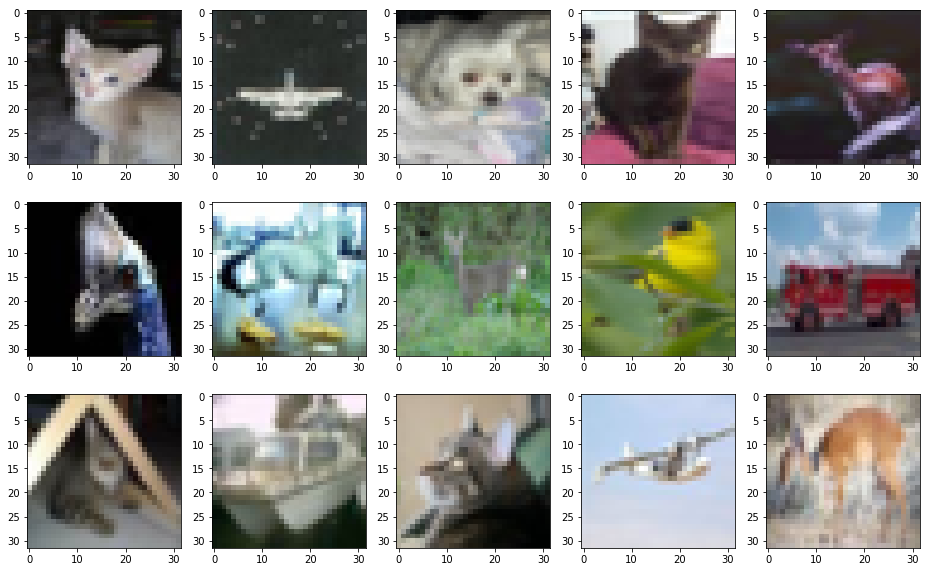

In [10]:
fig, axes = plt.subplots(3,5, figsize=(16,10))

for i in range(3):
    for j in range(5):
        axes[i, j].imshow(X_train[np.random.randint(50000, size=1)[0]][:,:,:])

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2)

In [12]:
X_train.shape

(40000, 32, 32, 3)

In [13]:
# X_train = X_train.reshape(X_train.shape[0], 30, 30, 3).astype('float32')
# X_test = X_test.reshape(X_test.shape[0], 3, 224, 224).astype('float32')

In [14]:
num_class = 10
# Convert class vectors to binary class matrices.
y_train = k.utils.to_categorical(y_train, num_class)
#y_test = k.utils.to_categorical(y_test, num_class)

In [15]:
pretrained_model = k.applications.resnet50.ResNet50(weights=RESNET50_WEIGHTS)

In [16]:
print('Output_layer_type= {}'.format(pretrained_model.layers[-1]))
print('Output_layer_shape= {}'.format(pretrained_model.layers[-1].output_shape))

Output_layer_type= <keras.layers.core.Dense object at 0x7f8199dadf60>
Output_layer_shape= (None, 1000)


In [17]:
pretrained_model.layers.pop()

In [18]:
print('Output_layer_type= {}'.format(pretrained_model.layers[-1]))
print('Output_layer_shape= {}'.format(pretrained_model.layers[-1].output_shape))

Output_layer_type= <keras.layers.pooling.GlobalAveragePooling2D object at 0x7f8199dd9a58>
Output_layer_shape= (None, 2048)


In [19]:
pretrained_model.layers

In [20]:
len(pretrained_model.layers)

176

In [21]:
for layer in pretrained_model.layers[0:-21]:
    layer.trainable = False

In [22]:
from keras.layers import ZeroPadding2D
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D

In [23]:
model = k.models.Sequential()
model.add(ZeroPadding2D((96, 96), input_shape=(32, 32,  3)))
model.add(pretrained_model)
#model.add(k.layers.Flatten())
#model.add(k.layers.GlobalAveragePooling2D())
#model.add(k.layers.Dense(1024, activation='relu'))
model.add(k.layers.Dense(num_class, activation='softmax'))

In [24]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [25]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_1 (ZeroPaddin (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Model)             (None, 1000)              23587712  
_________________________________________________________________
dense_1 (Dense)              (None, 10)                10010     
Total params: 23,597,722
Trainable params: 8,941,338
Non-trainable params: 14,656,384
_________________________________________________________________


In [26]:
print('Input Shape = {}'.format(model.layers[0].input_shape))
print('output Shape = {}'.format(model.layers[-1].output_shape))

Input Shape = (None, 32, 32, 3)
output Shape = (None, 10)


In [27]:
from keras.preprocessing.image import ImageDataGenerator

In [28]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

In [29]:
test_datagen = ImageDataGenerator(rescale = 1./255)

In [30]:
training_set = train_datagen.flow(X_train, y_train, batch_size = 32)

In [31]:
test_set = test_datagen.flow(X_test, y_test, batch_size = 32)

In [32]:
import keras
keras.__version__

'2.2.4'

In [33]:
len_tr = len(training_set)
len_te = len(test_set)
print(len_tr)
print(len_te)

1250
313


In [34]:
# model.fit_generator(training_set,
#                          samples_per_epoch = len_tr,
#                          nb_epoch = 25,
#                          validation_data = test_set,
#                          nb_val_samples = len_te)

In [35]:
model.fit_generator(training_set,
                         samples_per_epoch = len_tr,
                         nb_epoch = 300)

Instructions for updating:
Use tf.cast instead.


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., steps_per_epoch=39, epochs=300)`
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/300
39/39 [==============================] - 8s 205ms/step - loss: 2.2958 - acc: 0.1418
Epoch 2/300
39/39 [==============================] - 3s 75ms/step - loss: 2.2816 - acc: 0.2244
Epoch 3/300
39/39 [==============================] - 3s 75ms/step - loss: 2.2625 - acc: 0.2484
Epoch 4/300
39/39 [==============================] - 3s 76ms/step - loss: 2.2405 - acc: 0.2532
Epoch 5/300
39/39 [==============================] - 3s 76ms/step - loss: 2.2246 - acc: 0.2196
Epoch 6/300
39/39 [==============================] - 3s 76ms/step - loss: 2.2076 - acc: 0.2035
Epoch 7/300
39/39 [==============================] - 3s 76ms/step - loss: 2.1776 - acc: 0.2708
Epoch 8/300
39/39 [==============================] - 3s 76ms/step - loss: 2.1619 - acc: 0.2532
Epoch 9/300
39/39 [==============================] - 3s 76ms/step - loss: 2.1561 - acc: 0.2364
Epoch 10/300
39/39 [==============================] - 3s 76ms/step - loss: 2.1366 - acc: 0.2436
Epoch 11/300
39/39 [============================

In [36]:
predicto = model.predict_classes(X_test)

In [37]:
predicto.shape

(10000,)

In [38]:
y_test.shape

(10000, 1)

In [39]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, predicto)

0.1333

In [40]:
predicto

array([3, 3, 3, ..., 3, 3, 3])

In [41]:
y_test

array([[5],
       [1],
       [3],
       ...,
       [8],
       [4],
       [1]], dtype=uint8)

In [42]:
name = {0:"airplane", 1:"automobile", 2:"bird", 3:"cat", 4:"deer", 5:"dog", 6:"frog", 7:"horse", 8:"ship", 9:"truck"}

this is a dog -------- prediction is: cat
this is a frog -------- prediction is: frog
this is a automobile -------- prediction is: cat
this is a cat -------- prediction is: cat
this is a airplane -------- prediction is: cat
this is a horse -------- prediction is: cat
this is a airplane -------- prediction is: cat
this is a airplane -------- prediction is: cat
this is a airplane -------- prediction is: cat
this is a airplane -------- prediction is: cat
this is a cat -------- prediction is: cat
this is a bird -------- prediction is: cat
this is a truck -------- prediction is: truck
this is a automobile -------- prediction is: cat
this is a airplane -------- prediction is: cat


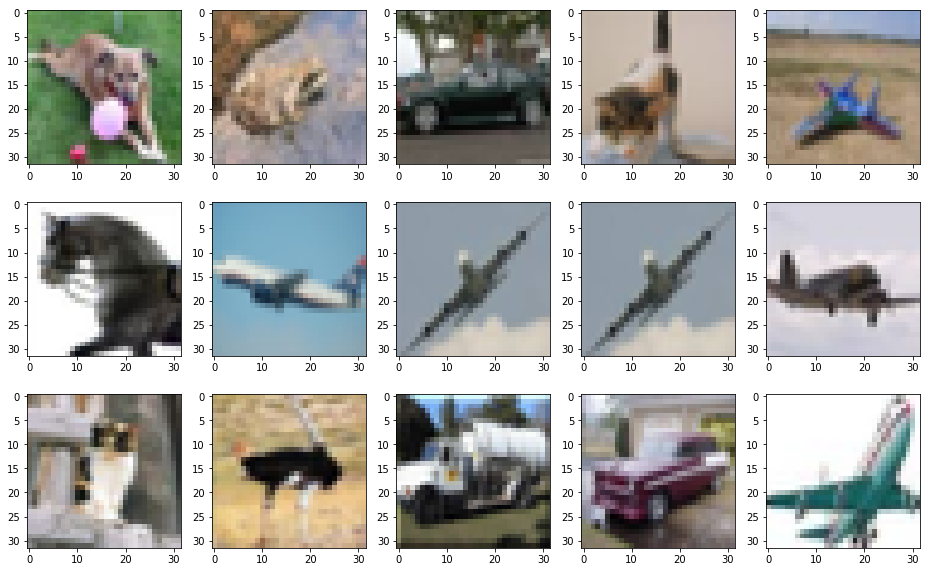

In [43]:
fig, axes = plt.subplots(3,5, figsize=(16,10))

for i in range(3):
    for j in range(5):
        r = np.random.randint(10000, size=1)[0]
        axes[i, j].imshow(X_test[r][:,:,:])
        #axes[i, j].title('dddd')
        print('this is a', name[y_test[r][0]], '-------- prediction is:', name[predicto[r]])